# Data pretreatment and Modelling Plan

Done by: Chamath Wijerathne, Nada Rahali, Tanjuma Haque

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [107]:
# loading the dataset from raw data folder
def load_and_prepare(file1, file2):
    # loading raw CSVs
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # merging row-wise
    df = pd.concat([df1, df2], axis=0, ignore_index=True)

    # removing  unwanted index columns (like "Unnamed: 0")
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    df1 = df1.loc[:, ~df1.columns.str.contains("^Unnamed")]
    df2 = df2.loc[:, ~df2.columns.str.contains("^Unnamed")]

    # splitting spectra (X) vs traits (Y)
    wl_cols = [c for c in df.columns if str(c).isdigit()]
    trait_cols = [c for c in df.columns if c not in wl_cols]


    X = df[wl_cols].copy()
    Y = df[trait_cols].copy()

    wls = np.array(list(map(int, X.columns)))

    trait_cols_df1 = [c for c in df1.columns if c not in wl_cols]
    trait_cols_df2 = [c for c in df2.columns if c not in wl_cols]
    Y_df1 = df1[trait_cols_df1].copy()
    Y_df2 = df2[trait_cols_df2].copy()

    print(f"Trait columns in df1: {Y_df1.columns.tolist()}")
    print(f"Trait columns in df2: {Y_df2.columns.tolist()}")

    print(f"Dataset loaded: {df.shape[0]} samples, {X.shape[1]} spectra, {Y.shape[1]} traits")
    return X, Y, df, df1, df2, wls

X, Y, df, df1, df2, wls = load_and_prepare("../data/raw/data_part_1.csv", "../data/raw/data_part_2.csv")

Trait columns in df1: ['Anthocyanin content (μg/cm²)', 'Boron content (mg/cm²)', 'C content (mg/cm²)', 'Ca content (mg/cm²)', 'Carotenoid content (μg/cm²)', 'Cellulose (mg/cm²)', 'Chl content (μg/cm²)', 'Copper content (mg/cm²)', 'EWT (mg/cm²)', 'Fiber (mg/cm²)', 'LAI (m²/m²)', 'LMA (g/m²)', 'Lignin (mg/cm²)', 'Magnesium content (mg/cm²)', 'Manganese content (mg/cm²)', 'N content (mg/cm²)', 'NSC (mg/cm²)', 'Phosphorus content (mg/cm²)', 'Potassium content (mg/cm²)', 'Sulfur content (mg/cm²)']
Trait columns in df2: ['Anthocyanin content (μg/cm²)', 'Anthocyanin concentration (mg/g)', 'Boron content (mg/cm²)', 'Boron concentration (mg/g)', 'C content (mg/cm²)', 'C concentration (mg/g)', 'Ca content (mg/cm²)', 'Ca concentration (mg/g)', 'Carotenoid content (μg/cm²)', 'Carotenoid concentration (mg/g)', 'Cellulose (mg/cm²)', 'Cellulose (mg/g)', 'Chl content (μg/cm²)', 'Chlorophyll concentration (mg/g)', 'Copper content (mg/cm²)', 'Copper concentration (mg/g)', 'EWT (mg/cm²)', 'Fiber (mg/cm²)

In [108]:
# quick look at the data
df.head()

,Anthocyanin content (μg/cm²),Boron content (mg/cm²),C content (mg/cm²),Ca content (mg/cm²),Carotenoid content (μg/cm²),Cellulose (mg/cm²),Chl content (μg/cm²),Copper content (mg/cm²),EWT (mg/cm²),Fiber (mg/cm²),...,Copper concentration (mg/g),Fiber (mg/g),Lignin (mg/g),Magnesium concentration (mg/g),Manganese concentration (mg/g),N concentration (mg/g),NSC (mg/g),P concentration (mg/g),Potassium concentration (mg/g),Sulfur concentration (mg/g)
0,NaN,NaN,NaN,0.091526,NaN,NaN,34.047382,NaN,10.889923,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.038488,NaN,NaN,23.320021,NaN,10.270048,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.026577,NaN,NaN,27.098073,NaN,11.423791,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.013190,NaN,NaN,27.638014,NaN,13.132381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.082163,NaN,NaN,23.159727,NaN,11.625371,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Adjustment of the initial pretreatment plan

### Feedback: Drop duplicate columns in a different measurement unit and we will be focusing on the common traits between the two datasets

Upon visual inspection from above, traits are measured in two ways (per-area vs per-mass) and both datasets have the per-mass while one dataset has extra, duplicate trait columns but for per-area. Example of unit differing duplicate columns:
- Chlorophyll content (μg/cm²) vs Chlorophyll concentration (mg/g)


In [109]:
# examing  traits: per-area vs per-mass
print("All traits:")
for col in Y.columns:
    print(f"  {col}")

# separating per-area and per-mass traits
per_area = [col for col in Y.columns if '(mg/cm²)' in col or '(μg/cm²)' in col or '(g/m²)' in col or '(m²/m²)' in col]
per_mass = [col for col in Y.columns if '(mg/g)' in col or 'concentration' in col]

# summary for traits verification 
print(f"Per-area: {len(per_area)} traits")
print(f"Per-mass: {len(per_mass)} traits")

All traits:
  Anthocyanin content (μg/cm²)
  Boron content (mg/cm²)
  C content (mg/cm²)
  Ca content (mg/cm²)
  Carotenoid content (μg/cm²)
  Cellulose (mg/cm²)
  Chl content (μg/cm²)
  Copper content (mg/cm²)
  EWT (mg/cm²)
  Fiber (mg/cm²)
  LAI (m²/m²)
  LMA (g/m²)
  Lignin (mg/cm²)
  Magnesium content (mg/cm²)
  Manganese content (mg/cm²)
  N content (mg/cm²)
  NSC (mg/cm²)
  Phosphorus content (mg/cm²)
  Potassium content (mg/cm²)
  Sulfur content (mg/cm²)
  Anthocyanin concentration (mg/g)
  Boron concentration (mg/g)
  C concentration (mg/g)
  Ca concentration (mg/g)
  Carotenoid concentration (mg/g)
  Cellulose (mg/g)
  Chlorophyll concentration (mg/g)
  Copper concentration (mg/g)
  Fiber (mg/g)
  Lignin (mg/g)
  Magnesium concentration (mg/g)
  Manganese concentration (mg/g)
  N concentration (mg/g)
  NSC (mg/g)
  P concentration (mg/g)
  Potassium concentration (mg/g)
  Sulfur concentration (mg/g)
Per-area: 20 traits
Per-mass: 17 traits


In [110]:
# dropping the duplicates per-mass traits
Y_cleaned = Y.drop(columns=per_mass)
print(f"After dropping per-mass traits, {Y_cleaned.shape[1]} traits remain.")
print("Traits kept:")
for col in Y_cleaned.columns:
    print(" -", col)

After dropping per-mass traits, 20 traits remain.
Traits kept:
 - Anthocyanin content (μg/cm²)
 - Boron content (mg/cm²)
 - C content (mg/cm²)
 - Ca content (mg/cm²)
 - Carotenoid content (μg/cm²)
 - Cellulose (mg/cm²)
 - Chl content (μg/cm²)
 - Copper content (mg/cm²)
 - EWT (mg/cm²)
 - Fiber (mg/cm²)
 - LAI (m²/m²)
 - LMA (g/m²)
 - Lignin (mg/cm²)
 - Magnesium content (mg/cm²)
 - Manganese content (mg/cm²)
 - N content (mg/cm²)
 - NSC (mg/cm²)
 - Phosphorus content (mg/cm²)
 - Potassium content (mg/cm²)
 - Sulfur content (mg/cm²)


### Feedback: Dimensionality reduction of spectra (X)

This is done following these steps:  
- **Feature Scaling:** Standardization for spectra (X)  
- **Dimensionality Reduction:** Apply PCA only on spectra (X)  

In [111]:
# Feature Scaling: Standardization for spectra (X)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

print("Shape:", X_standardized.shape)
print("First 5 rows of scaled spectra:\n", X_standardized[:5])


Shape: (13295, 1721)
First 5 rows of scaled spectra:
 [[-0.73418173 -0.73220769 -0.73024257 ... -0.42835896 -0.43054165
  -0.43266993]
 [-0.18719593 -0.18604869 -0.18493361 ... -0.16992794 -0.17216761
  -0.17436939]
 [-1.54933788 -1.54724072 -1.54511804 ... -0.59609598 -0.59602438
  -0.59591402]
 [-0.51071542 -0.50875683 -0.50681668 ... -0.37324959 -0.37814915
  -0.38296573]
 [-0.54359752 -0.53958046 -0.53558011 ... -0.15213944 -0.15978976
  -0.16733913]]


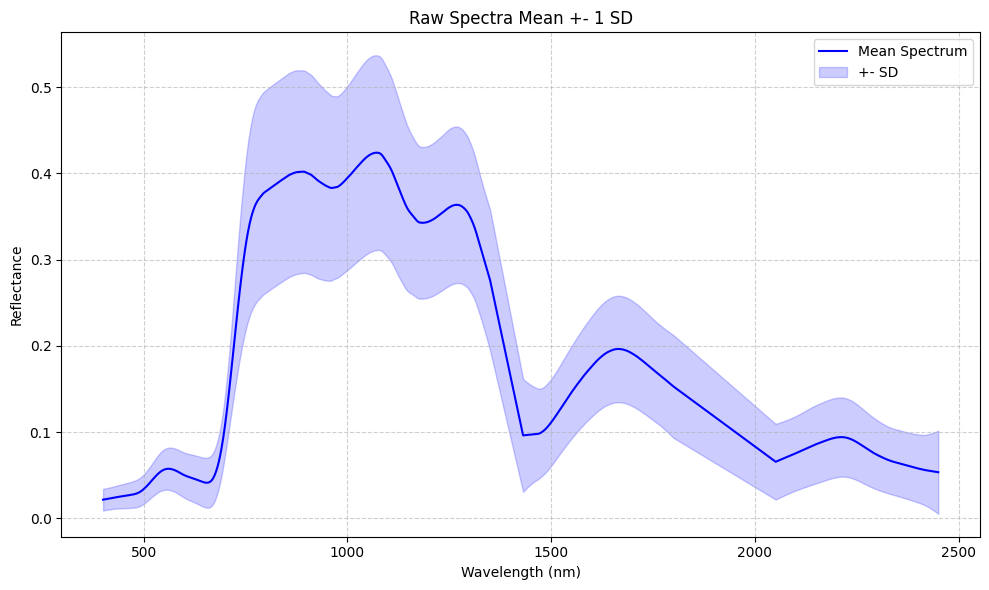

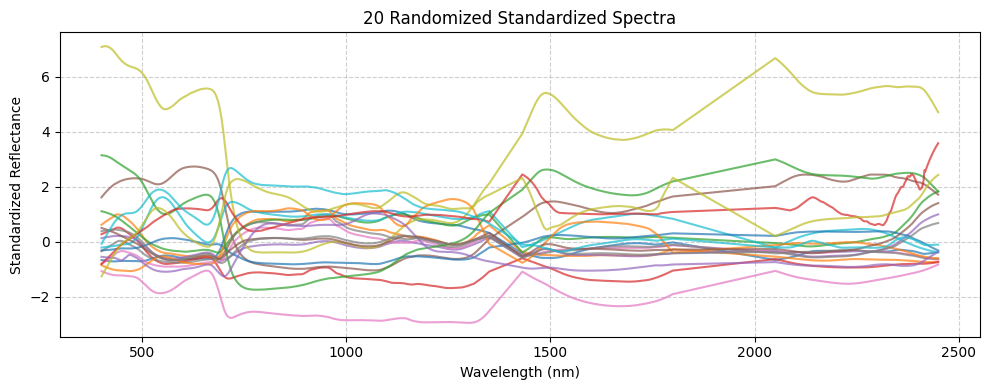

In [112]:

# plotting raw (unscaled) spectra mean +- 1 SD 
mu_raw = X.mean(axis=0).values
sd_raw = X.std(axis=0).values

plt.figure(figsize=(10, 6))
plt.plot(wls, mu_raw, label='Mean Spectrum', color='blue')
plt.fill_between(wls, mu_raw - sd_raw, mu_raw + sd_raw, 
                 color='blue', alpha=0.2, label='+- SD')
plt.title('Raw Spectra Mean +- 1 SD')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# plotting 20 randomized standardized spectra (post-scaling)
np.random.seed(42)
random_indices = np.random.choice(X_standardized.shape[0], size=20, replace=False)

plt.figure(figsize=(10,4))
for idx in random_indices:
    plt.plot(wls, X_standardized[idx, :], alpha=0.7)
plt.title("20 Randomized Standardized Spectra")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Standardized Reflectance")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [113]:
# applying PCA only on spectra (X)
pca = PCA()
X_pca = pca.fit_transform(X_standardized)
print("Shape of transformed spectra:", X_pca.shape)

# explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("Explained variance by each component:\n", explained_variance)
print("Cumulative explained variance:\n", cumulative_variance)


Shape of transformed spectra: (13295, 1721)
Explained variance by each component:
 [5.68562752e-01 3.14429092e-01 5.31225232e-02 ... 3.03870692e-21
 2.94146742e-21 2.93459678e-21]
Cumulative explained variance:
 [0.56856275 0.88299184 0.93611437 ... 1.         1.         1.        ]


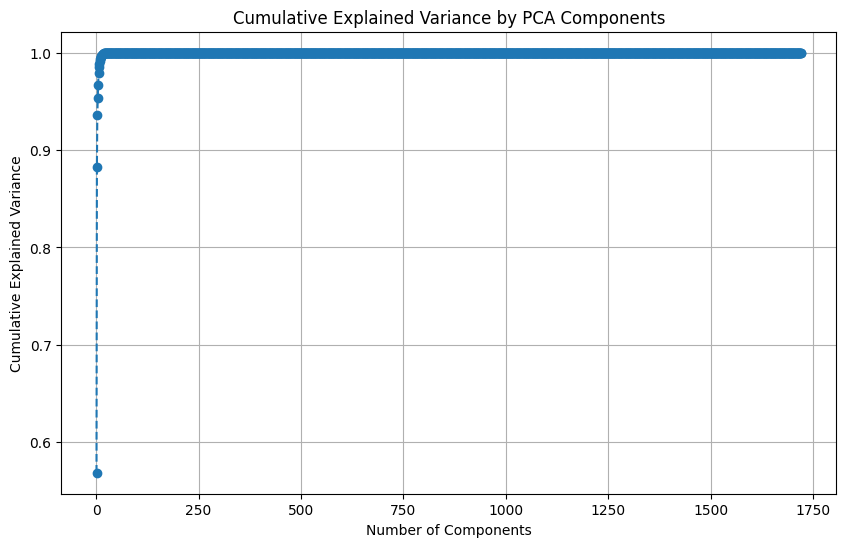

In [114]:
# plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()

In [115]:
# retaining just enough components to explain 95% of the total variance in the spectral data (X)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of PCs explaining 95% variance: {n_components}")

# re-running PCA with the selected number of components
pca_final = PCA(n_components=n_components)
X_reduced = pca_final.fit_transform(X_standardized)
print("Reduced shape:", X_reduced.shape)

Number of PCs explaining 95% variance: 4
Reduced shape: (13295, 4)


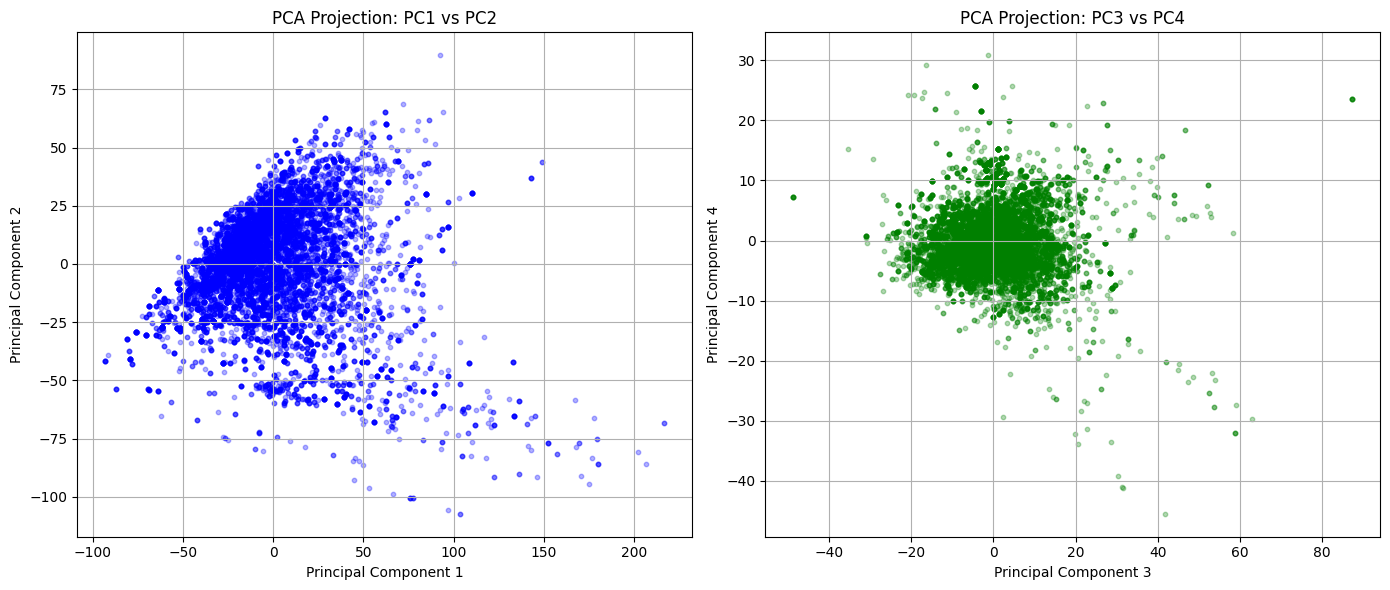

In [116]:
# plotting PC1 vs PC2 and PC3 vs PC4 from the reduced spectra
plt.figure(figsize=(14, 6))

# PC1 vs PC2
plt.subplot(1, 2, 1)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.3, s=10, c='b')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection: PC1 vs PC2")
plt.grid(True)

# PC3 vs PC4
if X_reduced.shape[1] >= 4:
    plt.subplot(1, 2, 2)
    plt.scatter(X_reduced[:, 2], X_reduced[:, 3], alpha=0.3, s=10, c='g')
    plt.xlabel("Principal Component 3")
    plt.ylabel("Principal Component 4")
    plt.title("PCA Projection: PC3 vs PC4")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [117]:
# checking the first few rows of the reduced data
print("First 5 rows of reduced spectra:\n", X_reduced[:5])

First 5 rows of reduced spectra:
 [[  6.67251194  16.2338331   -6.02340239  -2.24063524]
 [ -8.63131943 -19.38444832  -3.29468534  -3.15492669]
 [-14.7531551   -1.2156618   -7.92718512  -3.65048883]
 [ 24.13746802  14.45367583  -6.37663577  -6.71686094]
 [ 33.19133852   9.62741962  -6.67193725  -7.68075558]]


In [118]:
# checking missing values in both the spectra (X) and the traits (Y) so they could be dropped before modeling
print("Missing values in spectra:", X.isna().sum().sum())
print("Missing values in traits:", Y_cleaned.isna().sum().sum()) #not all trait values were measured

Missing values in spectra: 0
Missing values in traits: 175528


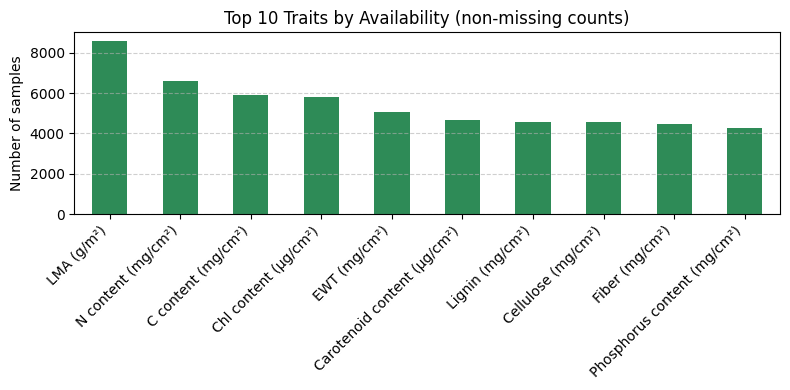

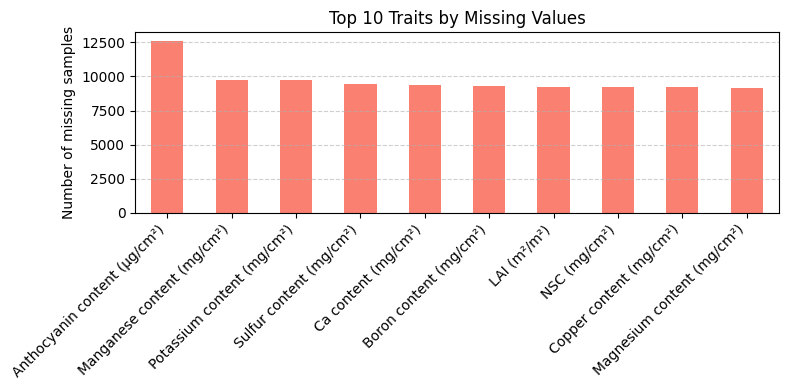

In [119]:
# trait availability (non-missing counts) and missingness
avail = Y_cleaned.notna().sum().sort_values(ascending=False)
miss  = Y_cleaned.isna().sum().sort_values(ascending=False)

# plotting top 10 available traits
plt.figure(figsize=(8,4))
avail.head(10).plot(kind='bar', color='seagreen')
plt.title("Top 10 Traits by Availability (non-missing counts)")
plt.ylabel("Number of samples")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# plotting top 10 traits with most missing values
plt.figure(figsize=(8,4))
miss.head(10).plot(kind='bar', color='salmon')
plt.title("Top 10 Traits by Missing Values")
plt.ylabel("Number of missing samples")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()